In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import torch 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.optim as optim

In [5]:
NUM_CLIENTS = 3

EPOCHS = 10
BATCH_SIZE = 100

IN_FEATURES = 3
HIDDEN_LAYERS = 128
OUT_FEATURES = 2

In [6]:
df = pd.read_csv('../datasets/label_data.csv')
df = df.rename(columns={'label': 'target'})
df.head()

,temperature,pressure,humidity,target
0,0.382509,0.601189,0.320719,0
1,0.716235,0.601189,0.309202,0
2,0.737459,0.601189,0.197776,0
3,0.970046,0.601189,0.790369,0
4,0.119006,0.601189,0.400452,0


In [7]:
df['target'].value_counts()

target
0    559718
1     90524
Name: count, dtype: int64

<Axes: title={'center': 'Labels Distribution'}>

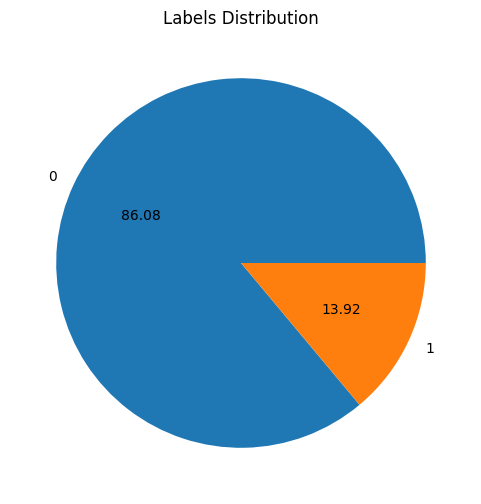

In [8]:
plt.title("Labels Distribution")
df.groupby('target').size().plot(kind='pie', autopct='%.2f', figsize=(6, 6))

In [9]:
feature = df.iloc[:, :-1]
feature.head()

,temperature,pressure,humidity
0,0.382509,0.601189,0.320719
1,0.716235,0.601189,0.309202
2,0.737459,0.601189,0.197776
3,0.970046,0.601189,0.790369
4,0.119006,0.601189,0.400452


In [10]:
target = df.loc[:, 'target']
target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [11]:
# Convert data to tensors and create a TensorDataset 
feature = torch.Tensor(feature.to_numpy())
print('Feature format: ', feature.shape, feature.dtype)
target = torch.tensor(target.to_numpy())
print('Target format: ', target.shape, target.dtype)
data = TensorDataset(feature, target) 

Feature format:  torch.Size([650242, 3]) torch.float32
Target format:  torch.Size([650242]) torch.int64


In [12]:
# Split to Train, Validate and Test sets
number_rows = len(feature)
test_split = int(number_rows * 0.3)
validate_split = int(number_rows * 0.1)
train_split = number_rows - test_split - validate_split
train_set, validate_set, test_set = random_split(data, [train_split, validate_split, test_split]) 

# Create Dataloader
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = BATCH_SIZE) 
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_layer, out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, hidden_layer), 
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer), 
            nn.ReLU(),
            nn.Linear(hidden_layer, out_features), 
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print('The model will be running on', device, "device\n") 

model = NeuralNetwork(IN_FEATURES, HIDDEN_LAYERS, OUT_FEATURES)
model.to(device)

The model will be running on cpu device


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)

In [14]:
def save_model(): 
    path = '../Testing/NNModel.pth'
    torch.save(model.state_dict(), path)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [16]:
def train(num_epochs): 
    best_accuracy = 0.0 
    print('Training start ...')
    
    for epoch in range(1, num_epochs + 1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
 
        # Training loop
        for data in train_loader:
            inputs, outputs = data
            optimizer.zero_grad()         
            predicted_outputs = model(inputs)
            train_loss = loss_fn(predicted_outputs, outputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        train_loss_value = running_train_loss / len(train_loader) 
 
        # Validation loop 
        with torch.no_grad(): 
            model.eval() 
            for data in validate_loader: 
               inputs, outputs = data 
               predicted_outputs = model(inputs) 
               val_loss = loss_fn(predicted_outputs, outputs) 
             
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 

        val_loss_value = running_vall_loss / len(validate_loader) 
        accuracy = (100 * running_accuracy / total)     
 
        if accuracy > best_accuracy: 
            save_model()
            best_accuracy = accuracy 
         
        print('Completed training batch', epoch, 'Training Loss is: %.4f' % train_loss_value, 'Validation Loss is: %.4f' % val_loss_value, 'Accuracy is %.4f' % accuracy)

In [17]:
def test(): 
    model = NeuralNetwork(IN_FEATURES, HIDDEN_LAYERS, OUT_FEATURES) 
    model.load_state_dict(torch.load('../Testing/NNModel.pth')) 
     
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 
 
        print('Accuracy of the model based on the test set of', test_split ,'inputs is: %.4f' % (100 * running_accuracy / total))

In [18]:
if __name__ == "__main__": 
    train(EPOCHS) 
    print('\nTraining Done.') 
    test()

Training start ...
Completed training batch 1 Training Loss is: 0.4533 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 2 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 3 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 4 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 5 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 6 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 7 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 8 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 9 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy is 85.9283
Completed training batch 10 Training Loss is: 0.4528 Validation Loss is: 0.4541 Accuracy i

Citation:   
https://flower.dev/docs/framework/tutorial-series-get-started-with-flower-pytorch.html
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html